## Лабораторная работа №4. ЭМГ - OpenBCI

**Выполнили:**
1. Алексеев Михаил Николаевич
2. Гурьянов Марк Владимирович
3. Ермаков Михаил Константинович 
4. Карандашева Надежда Алексеевна
5. Юсупова Эдна Эдуардовна

Загрузка данных и библиотек

In [ ]:
!wget -o log -O B_Thumb.csv 'https://docs.google.com/spreadsheets/d/1gdO6UXYM43qOTy-kGfvw6vL38WqJrDwgZJQ6JHuy3-Y/gviz/tq?tqx=out:csv&sheet=B_Thumb' 
!wget -o log -O Biceps.csv 'https://docs.google.com/spreadsheets/d/1TlhYQ-49A4-gtth8kXdhOOHdKioqbWXlZlH-GpqesgA/gviz/tq?tqx=out:csv&sheet=Biceps'
!wget -o log -O Circle.csv 'https://docs.google.com/spreadsheets/d/1t-oyLgcKL-e8wCJ4nFK5U46y7ITop2MhVhpr32ZTAas/gviz/tq?tqx=out:csv&sheet=Circle'
!wget -o log -O Delta.csv 'https://docs.google.com/spreadsheets/d/1J5Jul-dzkzexlG7UYDqLY8dphZhnX2F4lsxPe78di74/gviz/tq?tqx=out:csv&sheet=Delta'
!wget -o log -O Triceps.csv 'https://docs.google.com/spreadsheets/d/1gdO6UXYM43qOTy-kGfvw6vL38WqJrDwgZJQ6JHuy3-Y/gviz/tq?tqx=out:csv&sheet=Triceps'

In [ ]:
import numpy as np
from matplotlib import pyplot as plt 
import matplotlib.ticker as ticker
import pandas as pd
import scipy as sp
import scipy.interpolate
from scipy import stats
from scipy import signal
from statistics import mean
from tabulate import tabulate
from datetime import datetime

Были записаны 5 сигналов: 5 различных мышц. Переменная labels хранит перечесление мышц, которые были задействованы.

In [ ]:
labels=['B_Thumb', 'Biceps', 'Circle', 'Delta', 'Triceps']
s=[pd.read_csv('B_Thumb.csv'), 
   pd.read_csv('Biceps.csv'),
   pd.read_csv('Circle.csv'),
   pd.read_csv('Delta.csv'),
   pd.read_csv('Triceps.csv')]  
n_sig=len(s)
# удаление выбросов
for i in range(n_sig):
  s[i] = s[i].drop(s[i][s[i]['EXG Channel 0'] == 0].index)
  s[i] = s[i][(np.abs(stats.zscore(s[i]['EXG Channel 0'])) < 3)]

In [ ]:
signals=[{'l':labels[i], 't':s[i]['Timestamp (Formatted)'], 's':s[i]['EXG Channel 0'].to_list()} for i in range(n_sig)]

Что бы избавится от сигналов, которые повторяются, будем "растягивать" точи, попавшие на одинаковое значение времени в интервале от данной точки до следующей, присутствующей в сигнале.

In [ ]:
# time alignment
for sig in signals:  
  time=sig['t'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').timestamp())
  time=(time-time.iloc[0]).to_list() 
  i=0
  t=[]
  delta=0.05
  while i < len(time):
    j=i
    while time[j]-time[i]<delta:
      j+=1
      if j==len(time):
        t.extend(np.linspace(time[i],time[-1]+0.5,j-i+1)[:-1])
        break
    if j<len(time):
      t.extend(np.linspace(time[i],time[j],j-i+1)[:-1])
    i=j
  sig['t']=t

Построим полученные сигналы. Видно, что они имеют искажения, не имеющие отношения к ЭМГ. Прежде, чем приступать к обработке сигнала, попытаемся избавиться от этих искажений.

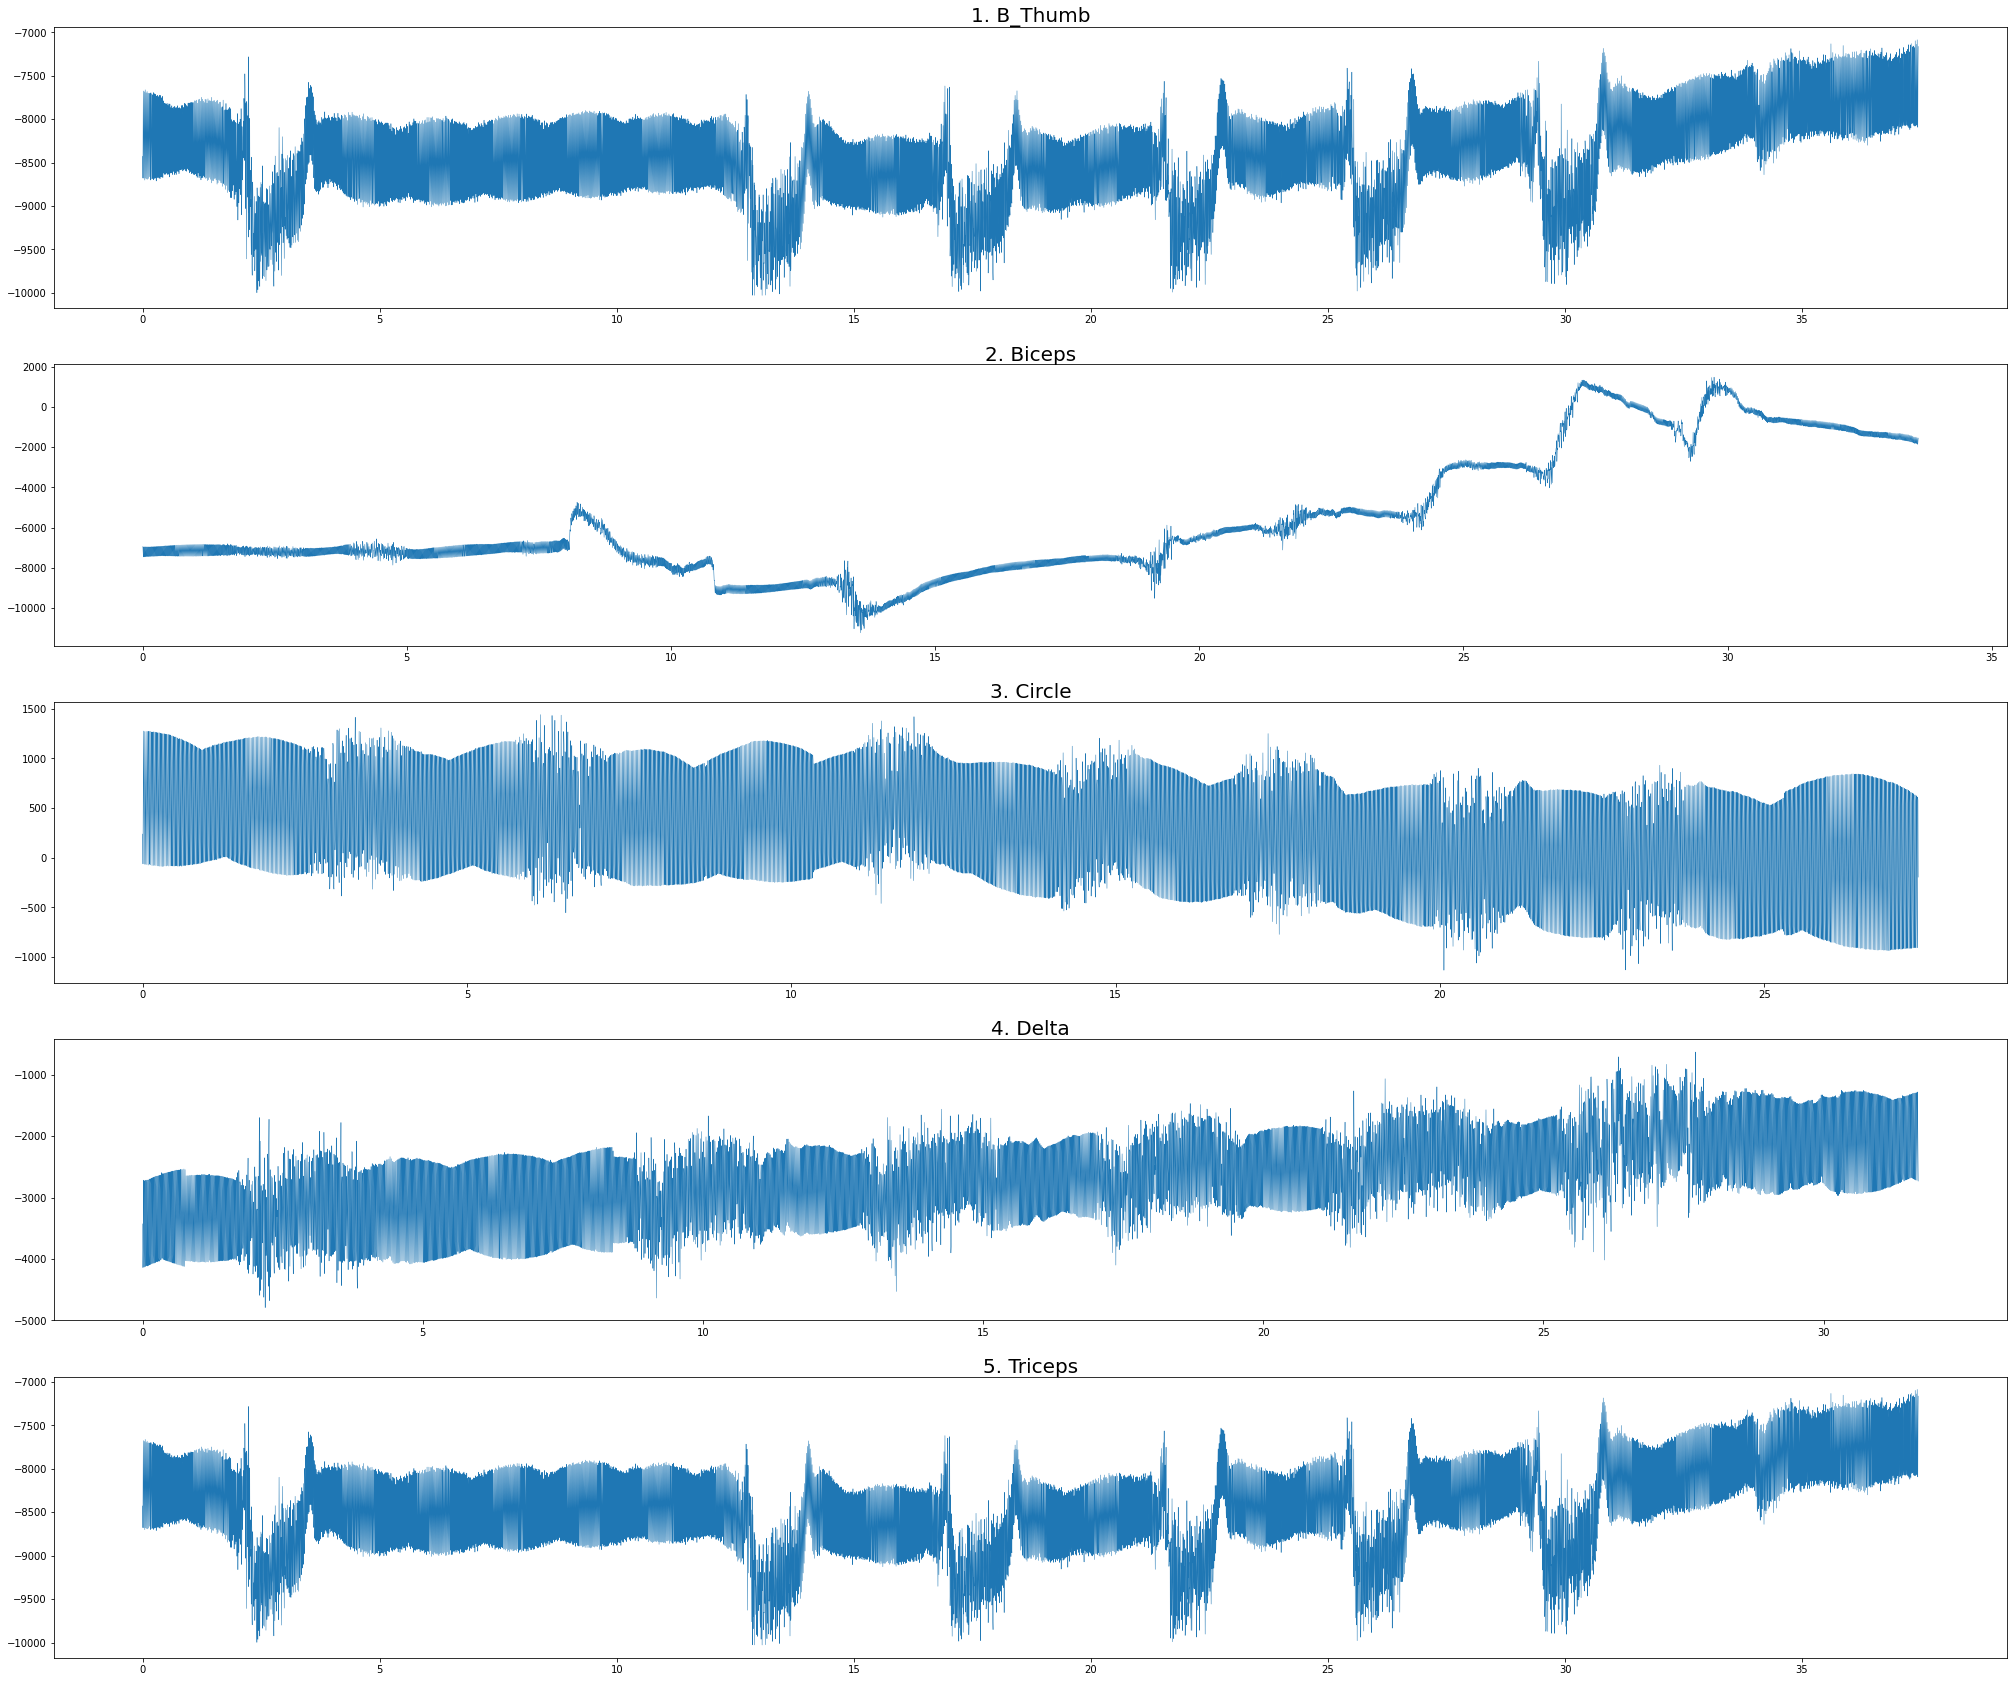

In [ ]:
fig, axs = plt.subplots(n_sig,1)
fig.set_size_inches(35, 6*n_sig, forward=True)
for i in range(n_sig):
  axs[i].plot(signals[i]['t'],signals[i]['s'],linewidth=0.5)
  axs[i].set_title(str(i+1)+'. '+signals[i]['l'],fontsize = 20,pad=-10)

Что бы все сигналы выглядили как равные линии с колебанием амблитуды, надо посчитать скользящее среднее для каждого сигнала, после вычтесть из исходного сигнала.
На изображении видна разница по сравнению с предыдущим выводом.

In [ ]:
# moving average
for sig in signals:
  eps=150
  a=[sig['s'][0]]*(eps//2)+sig['s']+[sig['s'][-1]]*(eps//2)
  ret = np.cumsum(a, dtype=float)
  ret[eps:] = ret[eps:] - ret[:-eps]
  sig['m']=ret[eps:] / eps
  sig['ms']=[a-b for (a,b) in zip(sig['s'],sig['m'])]

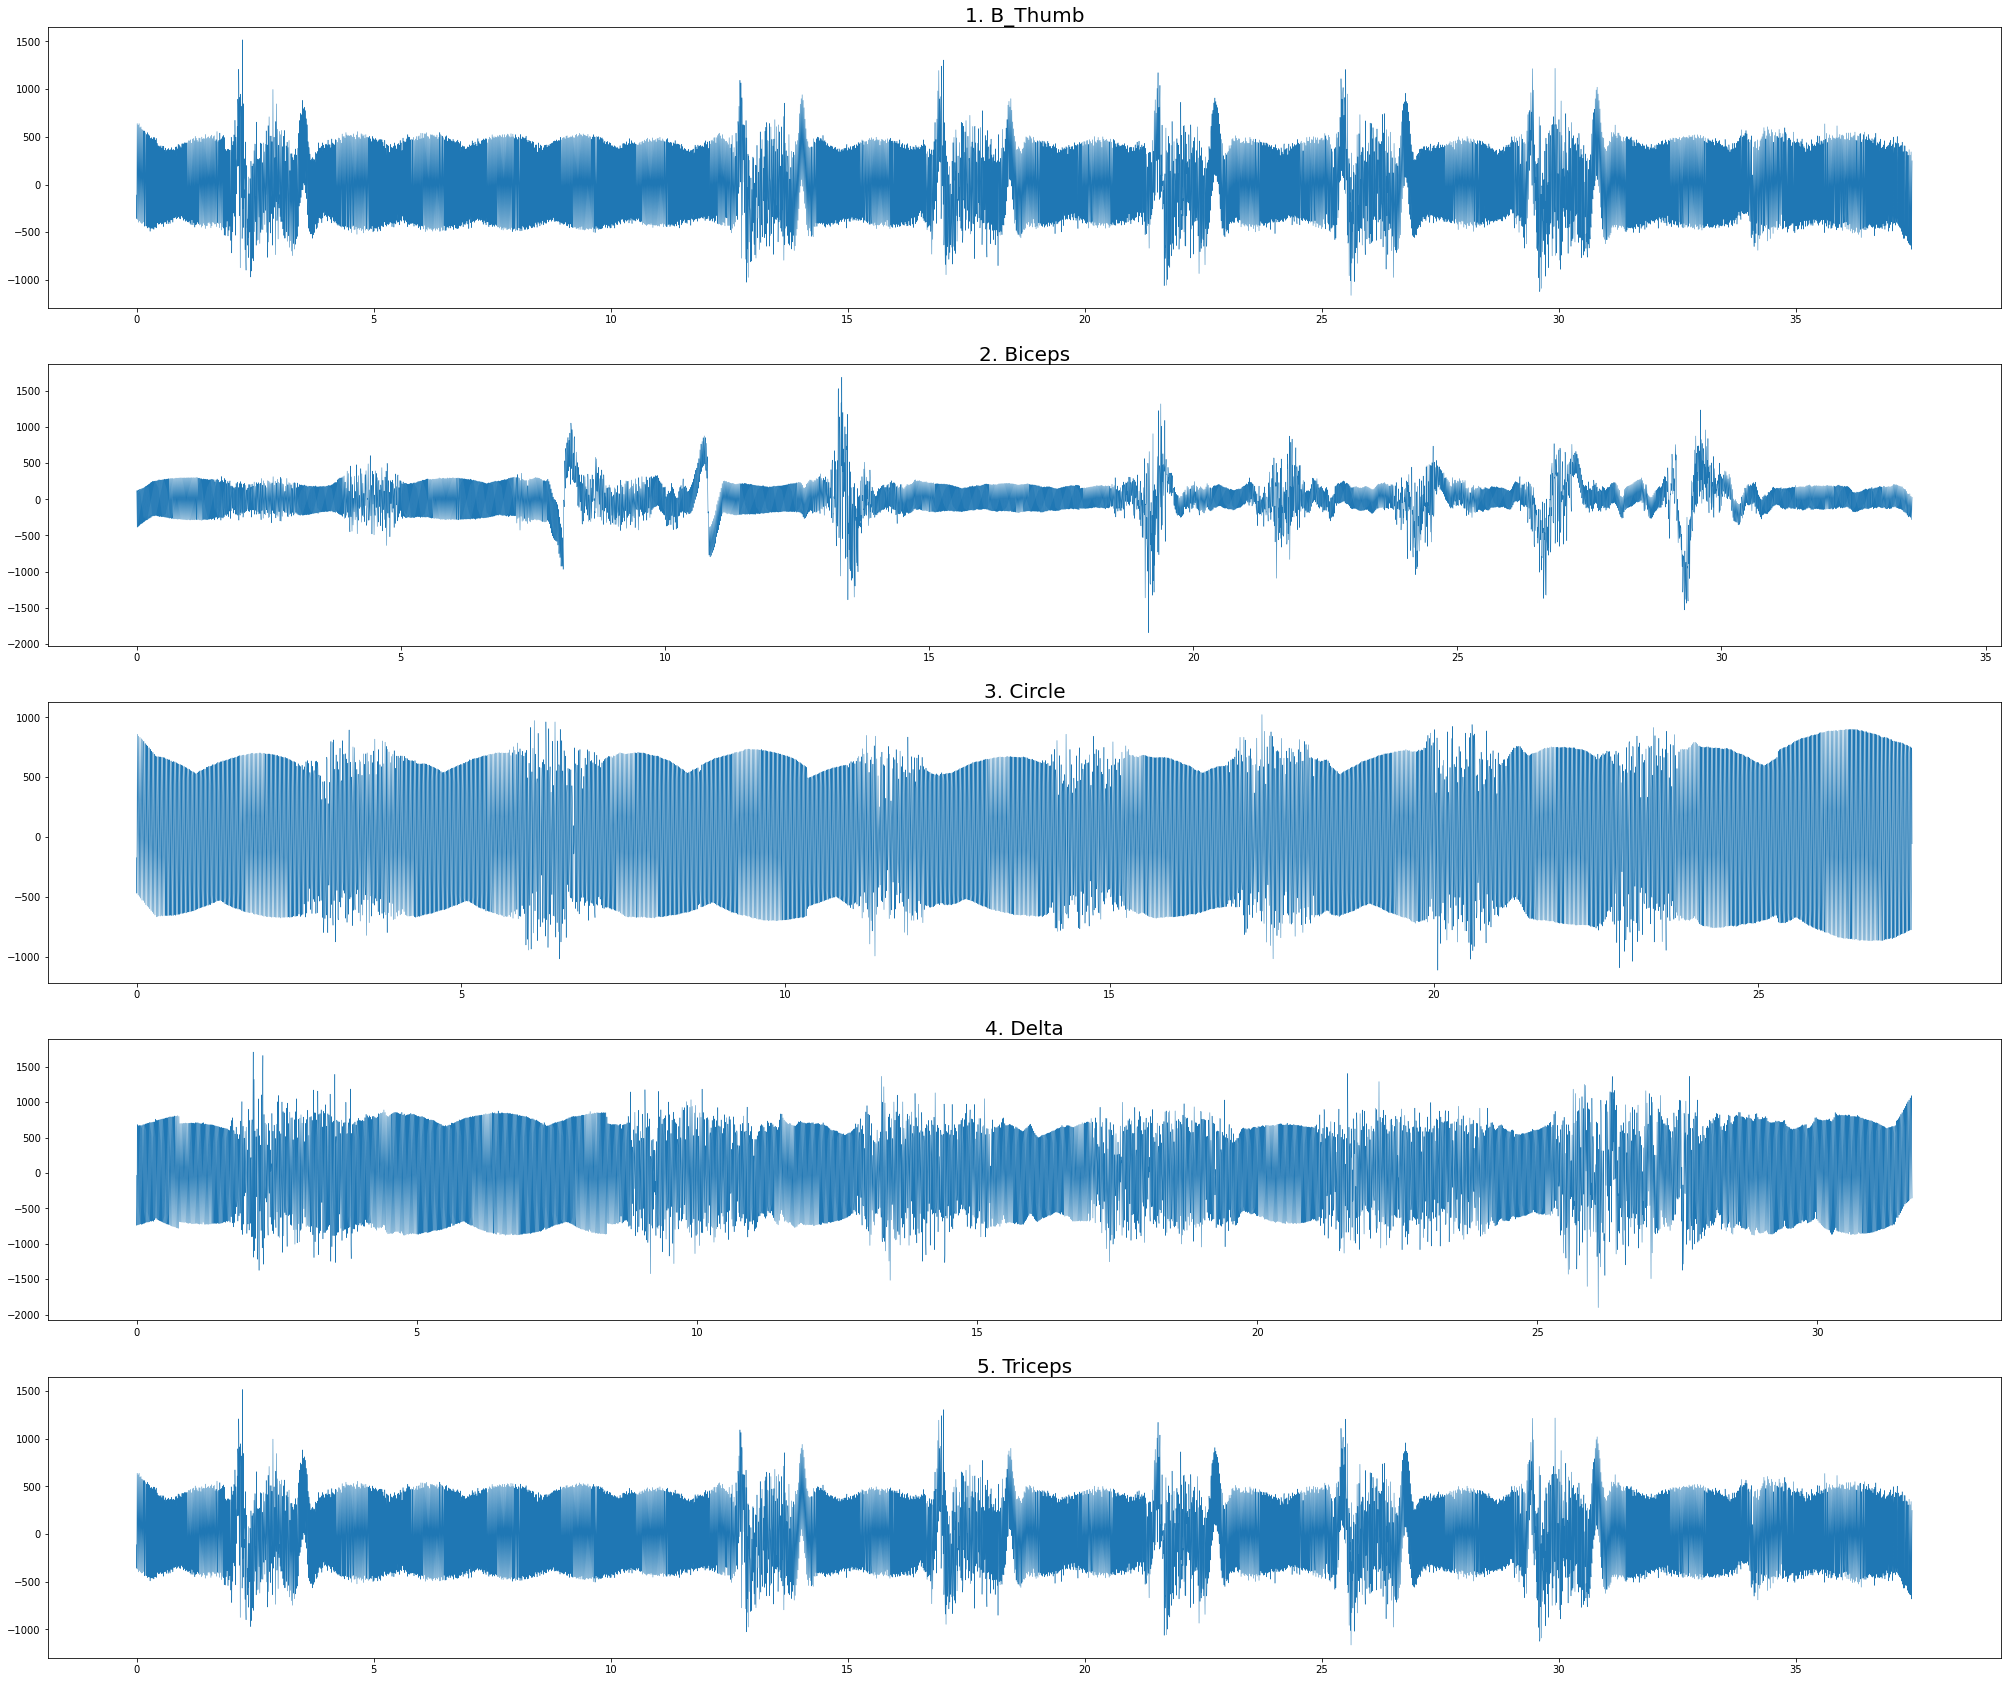

In [ ]:
fig, axs = plt.subplots(n_sig,1)
fig.set_size_inches(35, 6*n_sig, forward=True)
for i in range(n_sig):
  axs[i].plot(signals[i]['t'],signals[i]['ms'],linewidth=0.5)
  axs[i].set_title(str(i+1)+'. '+signals[i]['l'],fontsize = 20,pad=-10)

Видно, что сигнал сильно зашумлён. Воспользуемся полосовым фильтром Баттерворта, чтобы избавиться от шума. Фильтр Баттерворта проектируется так, чтобы его амплитудно-частотная характеристика была максимально гладкой на частотах полосы пропускания. 

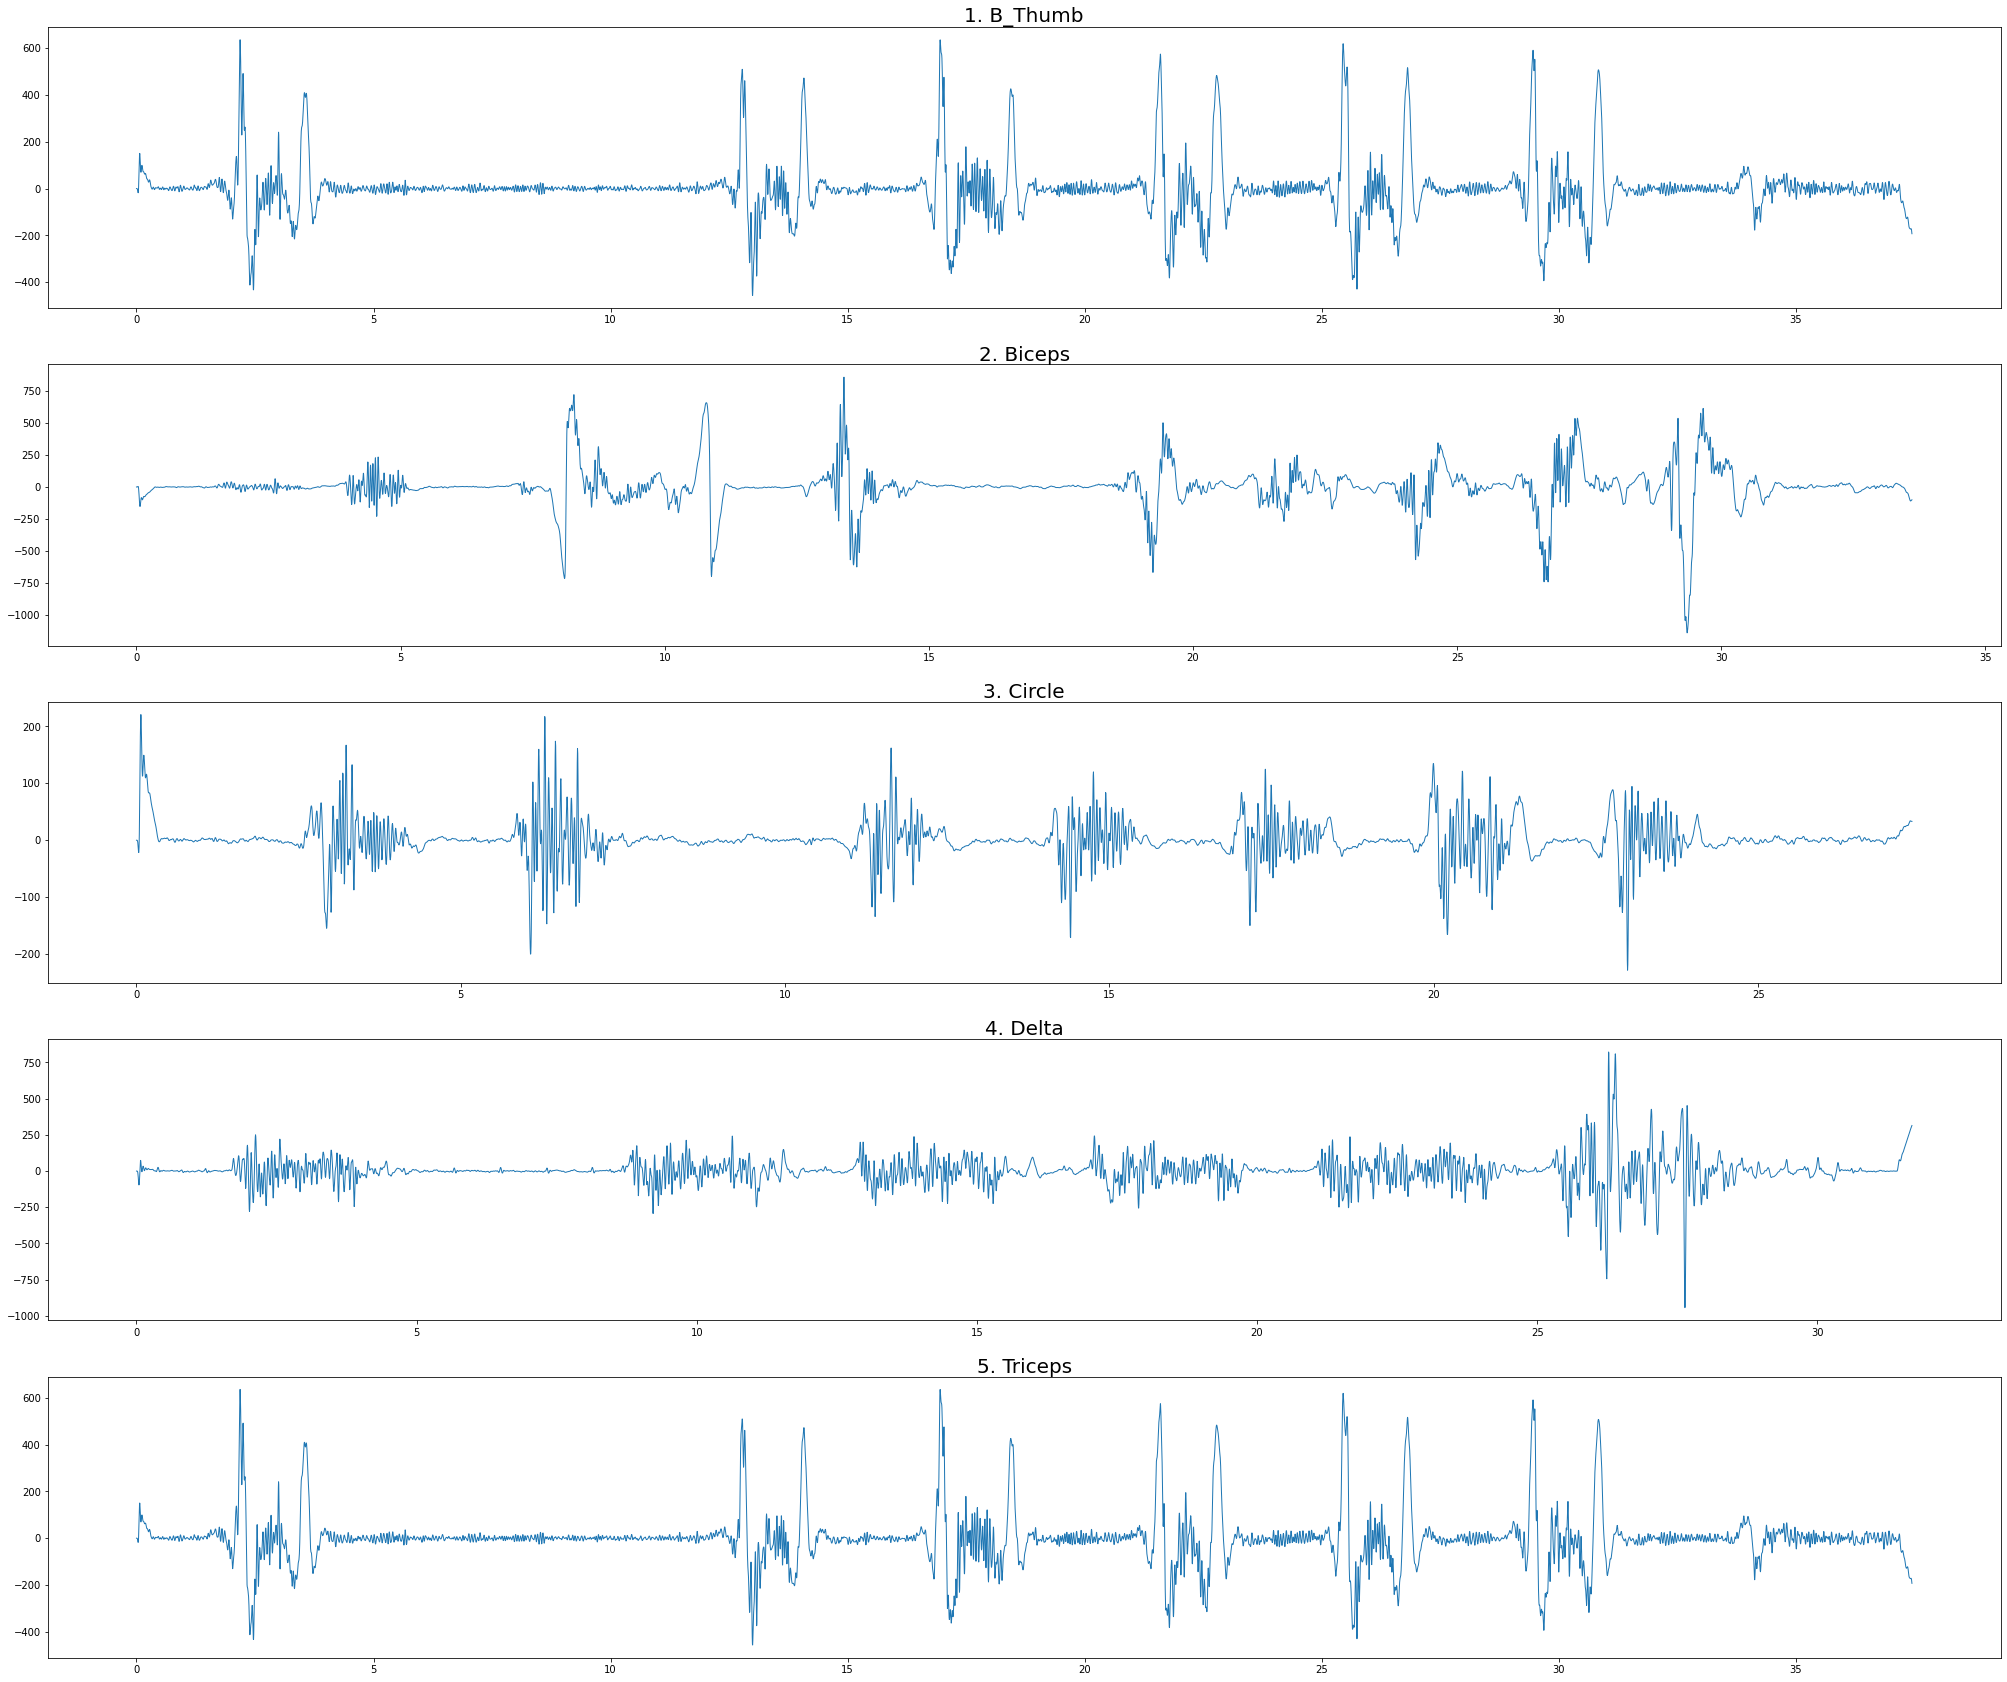

In [ ]:
b, a = signal.butter(9, 90, fs=1000, btype='low')
for sig in signals:
  sig['f'] = signal.lfilter(b, a, sig['ms'])

fig, axs = plt.subplots(n_sig,1)
fig.set_size_inches(35, 6*n_sig, forward=True)
for i in range(n_sig):
  # axs[i].plot(signals[i]['t'],signals[i]['ms'],linewidth=0.5)
  axs[i].plot(signals[i]['t'],signals[i]['f'],linewidth=1)
  axs[i].set_title(str(i+1)+'. '+signals[i]['l'],fontsize = 20,pad=-10)

Рассчитаем амплитуду сигнала. Также используя пороговое отсечение, преобразуем сигнал в дискретный, чтобы выявить периоды напряжения и расслабленности мышц.

In [ ]:
def discrete(sig, params):
  M=mean(sig['f'])
  eps=params[0]
  theta=params[1]
  delta=params[2]
  s=[M]*eps+list(sig['f'])+[M]*eps

  # подсчёт амплитуды через среднеквадратичное отклонение
  a=[np.std(s[i-eps:i+eps]) for i in range(eps, len(s)-eps)]

  # дискретизация
  d=[0 if abs(a[i])<=delta else 1 for i in range(len(a))]
  lastChange=0

  # удаление выбросов
  for i in range(1, len(d)):
    if d[i]!=d[i-1]:
      if sig['t'][i]-sig['t'][lastChange]<theta:
        d[lastChange:i]=[d[i]]*(i-lastChange)
      else:
        lastChange=i 
  sig['a']=a
  sig['d']=d

Сигналы имеют разную амплитуду и разные скорости колебания ампоитуд. Подберем для каждого сигнала параметры к описанной выше функции.

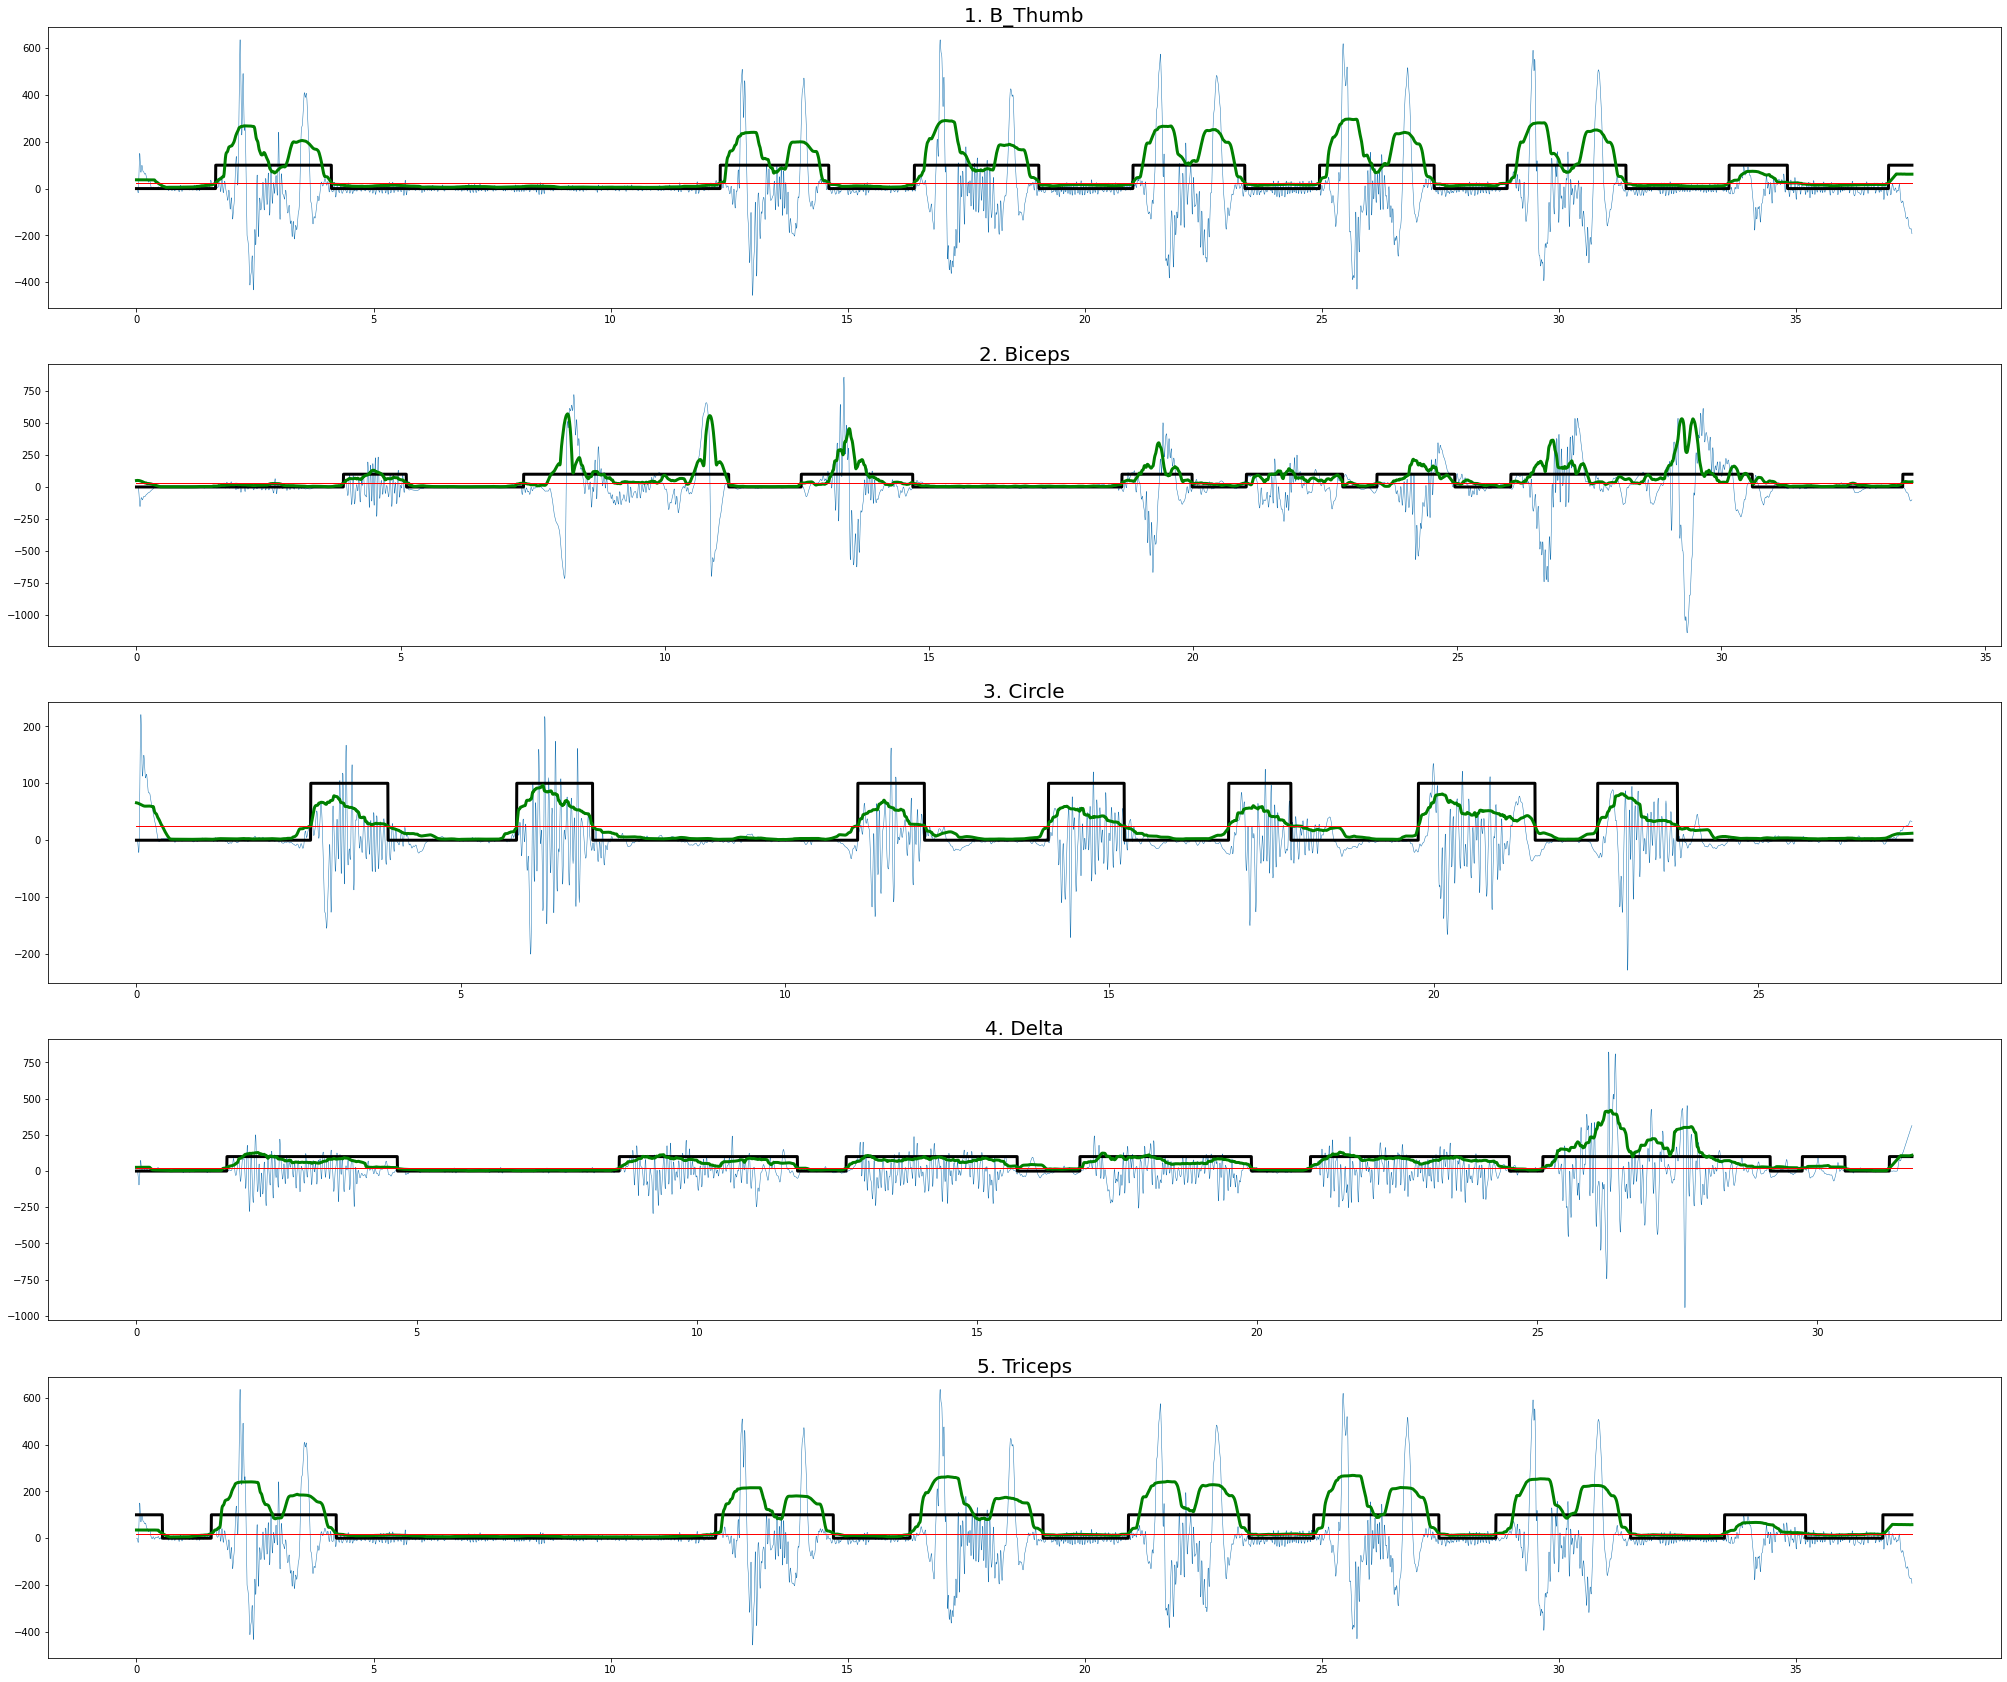

In [ ]:
params=[[80,0.5,25],  # 0
        [30,0.5,30],  # 1
        [50,0.5,25],  # 2
        [50,0.5,22],  # 3
        [100,0.5,20]] # 4
for i in range(n_sig):
  discrete(signals[i], params[i])
fig, axs = plt.subplots(n_sig,1)
fig.set_size_inches(35, 6*n_sig, forward=True)
for i in range(n_sig):
  axs[i].plot(signals[i]['t'],signals[i]['f'],linewidth=0.5)
  axs[i].plot(signals[i]['t'],[100*x for x in signals[i]['d']], 'k-',linewidth=3)
  axs[i].plot(signals[i]['t'],signals[i]['a'], 'g-',linewidth=3)
  axs[i].plot([0,signals[i]['t'][-1]],[params[i][2]]*2, 'r-',linewidth=1)
  axs[i].set_title(str(i+1)+'. '+signals[i]['l'],fontsize = 20,pad=-10)

plt.show()

Подсчитаем среднее напряжение во время напряжения мышц. Список в порядке уменьшения значения:
1. Мышца большого пальца - 150
2. Трицепс - 141 
3. Бицепс - 111
4. Дельта мышца - 90
5. Локтевая мышца - 51

Напрягать мышцы можно с разной силой, как видно из значений, при напряжении большого пальца испытуемый очень сильно его напряг, также в случае я бицепсом и трицепсом. Что касаемо дельта мышцы и локтевой мышцы, испытуемый не особо напрягался для работы этих мышц. 

In [ ]:
meanIntension=sorted([[i+1, signals[i]['l'], round(mean([signals[i]['a'][j] for j in range(len(signals[i]['a'])) if signals[i]['d'][j]==1]),2)] for i in range(n_sig)], key=lambda x: (x[2]))
print(tabulate(meanIntension, headers=['N','Excercise', 'Mean intension']))

  N  Excercise      Mean intension
---  -----------  ----------------
  3  Circle                  50.64
  4  Delta                   89.79
  2  Biceps                 110.72
  5  Triceps                140.78
  1  B_Thumb                150.17


### Вывод
В ходе выполнения лабораторной работы, были получены данные с 5 мышц. Из полученных сигналов электромиограммы были извлечены напряжение мыщц в моменты выполнения физических упражнений.

Также с помощью настройки параметров для упражнения были извлечены дискретные сигналы напряжения мышц.